In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import load_img, img_to_array

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [6]:
def collect_data(path: str) -> tuple:
    image_paths, emotions = [], []
    for emotion in os.listdir(path):
        for image_name in os.listdir(os.path.join(path, emotion)):
            if '.ipynb_checkpoints' not in image_name:
                image_paths.append(os.path.join(path, emotion, image_name).replace('/', '\\'))
                emotions.append(emotion)
    return image_paths, emotions

In [7]:
train_path, test_path = 'data/train/', 'data/test/'

In [8]:
df_train = pd.DataFrame()
df_train['image'], df_train['emotion'] = collect_data(train_path)
df_train

,image,emotion
0,data\train\angry\Training_10118481.jpg,angry
1,data\train\angry\Training_10120469.jpg,angry
2,data\train\angry\Training_10131352.jpg,angry
3,data\train\angry\Training_10161559.jpg,angry
4,data\train\angry\Training_1021836.jpg,angry
...,...,...
28704,data\train\surprise\Training_99916297.jpg,surprise
28705,data\train\surprise\Training_99924420.jpg,surprise
28706,data\train\surprise\Training_99937001.jpg,surprise
28707,data\train\surprise\Training_99951755.jpg,surprise


In [9]:
df_test = pd.DataFrame()
df_test['image'], df_test['emotion'] = collect_data(test_path)
df_test

,image,emotion
0,data\test\angry\PrivateTest_10131363.jpg,angry
1,data\test\angry\PrivateTest_10304478.jpg,angry
2,data\test\angry\PrivateTest_1054527.jpg,angry
3,data\test\angry\PrivateTest_10590091.jpg,angry
4,data\test\angry\PrivateTest_1109992.jpg,angry
...,...,...
7173,data\test\surprise\PublicTest_98089595.jpg,surprise
7174,data\test\surprise\PublicTest_98567249.jpg,surprise
7175,data\test\surprise\PublicTest_98972870.jpg,surprise
7176,data\test\surprise\PublicTest_99242645.jpg,surprise


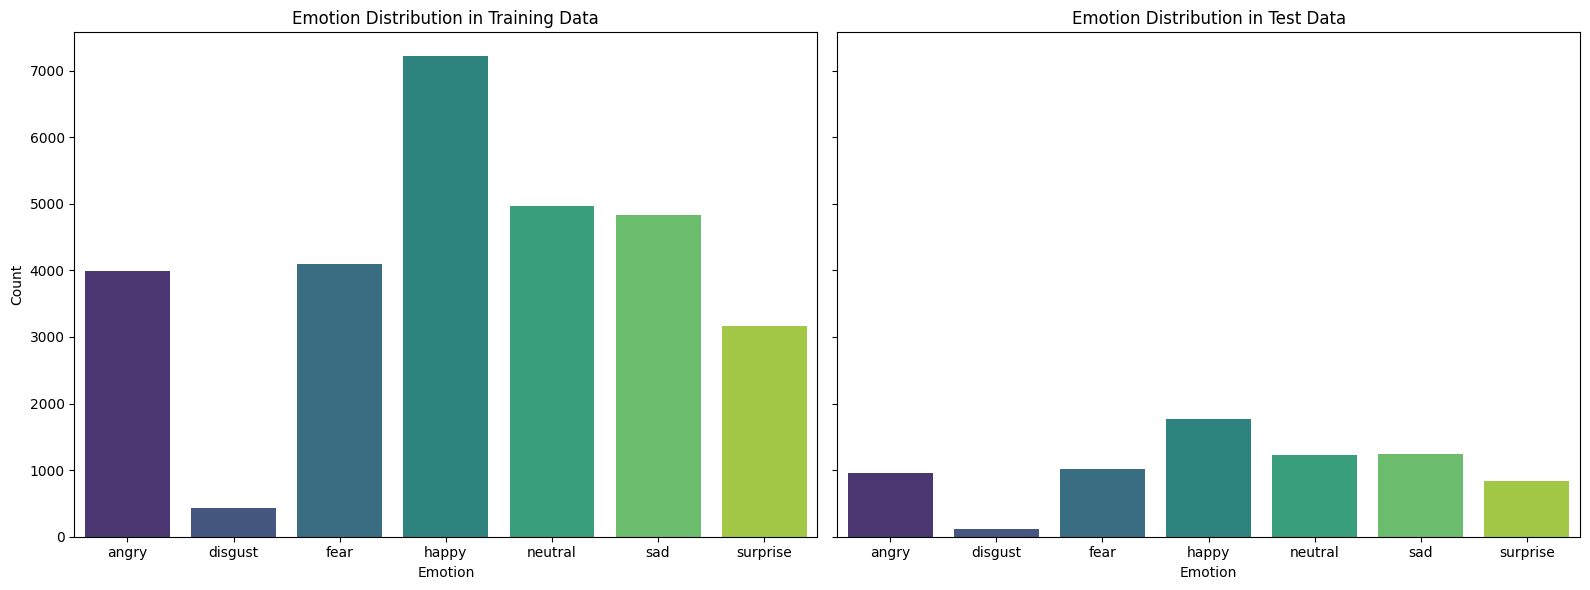

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.countplot(ax=axes[0], x='emotion', hue='emotion', data=df_train, palette='viridis', legend=False)
axes[0].set_title('Emotion Distribution in Training Data')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')

sns.countplot(ax=axes[1], x='emotion', hue='emotion', data=df_test, palette='viridis', legend=False)
axes[1].set_title('Emotion Distribution in Test Data')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

In [11]:
def extract_features(emotions: pd.Series) -> np.array:
    features = []
    for emotion in tqdm(emotions):
            features.append(
                np.array(
                    load_img(emotion, color_mode='grayscale')
                )
            )
            
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)

    return features

In [12]:
features_train = extract_features(df_train['image'])
features_test = extract_features(df_test['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
X_train, X_test = features_train / 255., features_test / 255.

In [14]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train['emotion'])
y_test = encoder.transform(df_test['emotion'])

In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [16]:
X_train.shape, y_train.shape

((28709, 48, 48, 1), (28709, 7))

In [17]:
X_test.shape, y_test.shape

((7178, 48, 48, 1), (7178, 7))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

In [19]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
898/898 [==============================] - 40s 41ms/step - loss: 1.7360 - accuracy: 0.3082 - val_loss: 1.7167 - val_accuracy: 0.2694
Epoch 2/50
898/898 [==============================] - 36s 40ms/step - loss: 1.4466 - accuracy: 0.4407 - val_loss: 1.5022 - val_accuracy: 0.4210
Epoch 3/50
898/898 [==============================] - 38s 42ms/step - loss: 1.3328 - accuracy: 0.4918 - val_loss: 1.4164 - val_accuracy: 0.4237
Epoch 4/50
898/898 [==============================] - 37s 41ms/step - loss: 1.2752 - accuracy: 0.5147 - val_loss: 1.2885 - val_accuracy: 0.5034
Epoch 5/50
898/898 [==============================] - 37s 42ms/step - loss: 1.2252 - accuracy: 0.5388 - val_loss: 1.2252 - val_accuracy: 0.5600
Epoch 6/50
898/898 [==============================] - 37s 42ms/step - loss: 1.1788 - accuracy: 0.5561 - val_loss: 1.1695 - val_accuracy: 0.5597
Epoch 7/50
898/898 [==============================] - 37s 42ms/step - loss: 1.1394 - accuracy: 0.5735 - val_loss: 1.0374 - val_accuracy:

<Axes: >

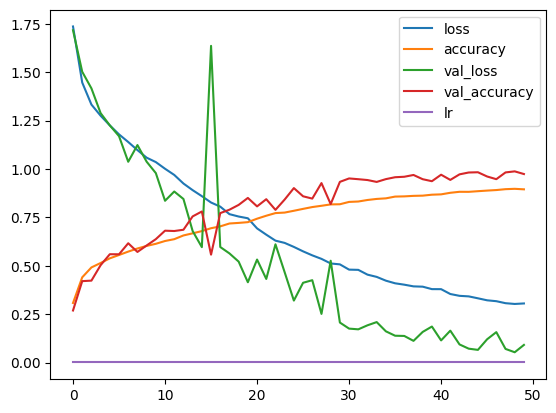

In [23]:
pd.DataFrame(history.history).plot()

In [24]:
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [30]:
from sklearn.metrics import classification_report


y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_classes = np.argmax(y_pred, axis=1)
labels = encoder.classes_

print(classification_report(y_true, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

       angry       0.60      0.46      0.52       958
     disgust       0.64      0.60      0.62       111
        fear       0.55      0.38      0.45      1024
       happy       0.78      0.86      0.81      1774
     neutral       0.51      0.69      0.59      1233
         sad       0.50      0.49      0.49      1247
    surprise       0.79      0.76      0.77       831

    accuracy                           0.63      7178
   macro avg       0.62      0.61      0.61      7178
weighted avg       0.63      0.63      0.62      7178



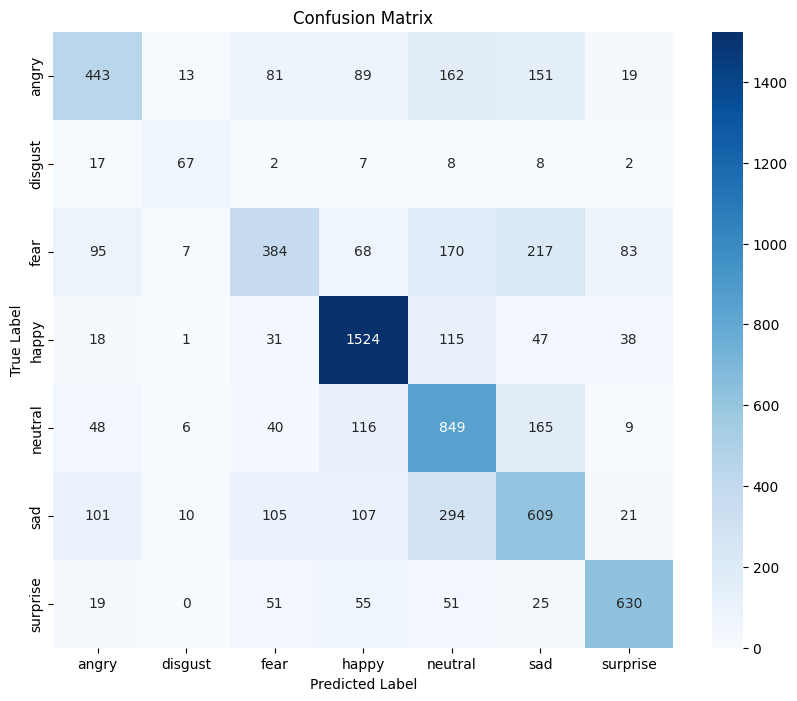

In [31]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

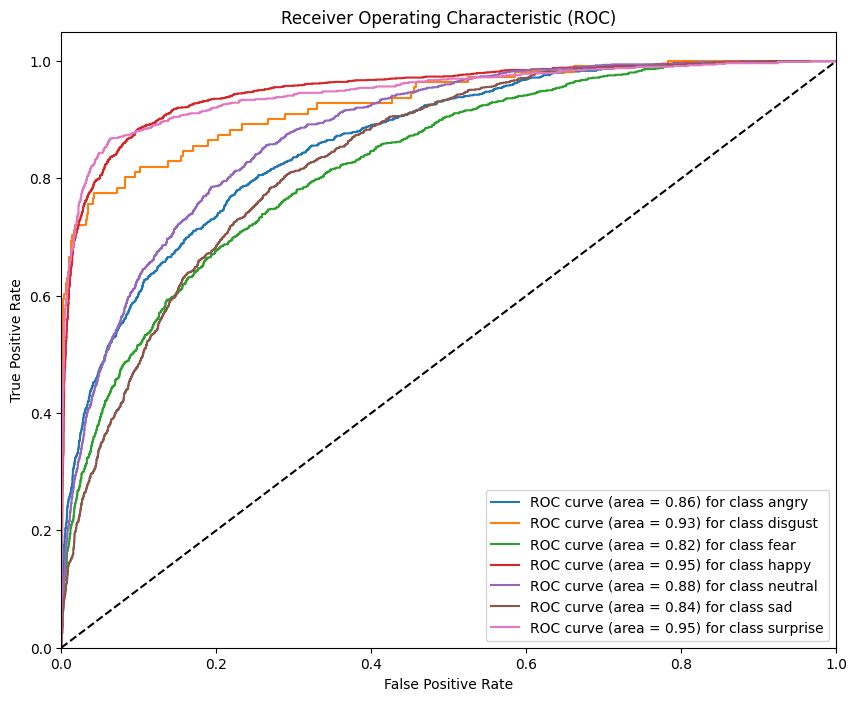

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {labels[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

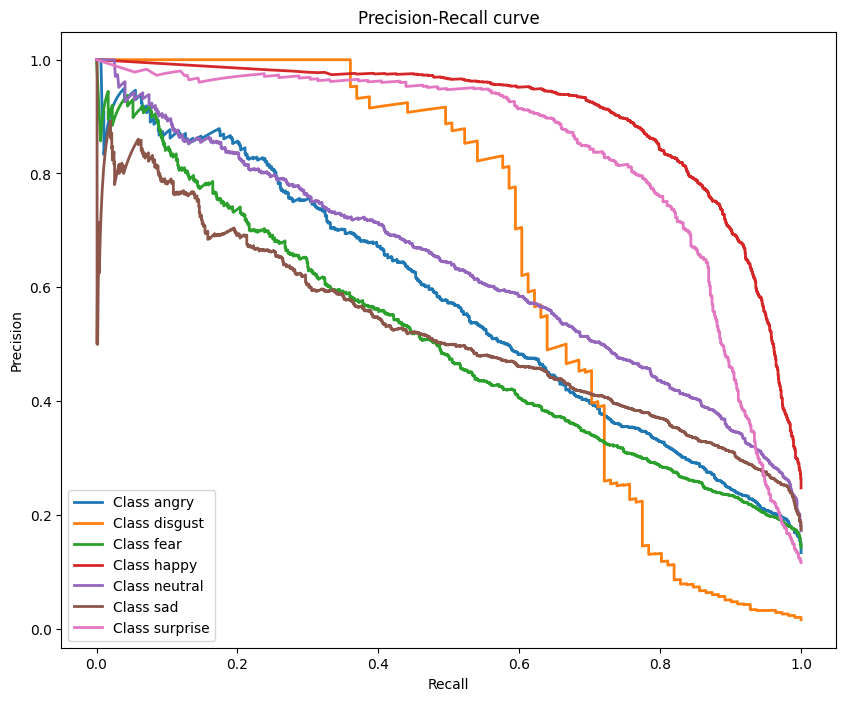

In [40]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {labels[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc="best")
plt.show()


In [33]:
model_json = model.to_json()

with open('model/emotion_recognition.json', 'w') as json_file:
    json_file.write(model_json)

model.save('model/emotion_recognition.h5')

In [34]:
from keras.models import model_from_json

In [35]:
json_file = open('model/emotion_recognition.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights('model/emotion_recognition.h5')

In [36]:
import cv2
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

cascade_path = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

if face_cascade.empty():
    raise IOError(f"Error loading cascade file at {cascade_path}")

def preprocess_image(img_path, desired_width, desired_height):
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Unable to load image at path {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        return None

    for (x, y, w, h) in faces:
        cropped_face = gray[y:y+h, x:x+w]
        break

    resized_face = cv2.resize(cropped_face, (desired_width, desired_height))

    preprocessed_face = resized_face / 255.0

    preprocessed_face = np.expand_dims(preprocessed_face, axis=0)
    preprocessed_face = np.expand_dims(preprocessed_face, axis=-1)

    return preprocessed_face

def predict_emotion(img_path, model, labels):
    feature = preprocess_image(img_path, 48,48)

    if feature is None:
        print("No face detected in the image or image could not be loaded.")
        return

    pred = model.predict(feature)
    pred_label = labels[np.argmax(pred)]
    print(f"Predicted emotion: {pred_label}")

    plt.imshow(feature[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted emotion: {pred_label}")
    plt.show()

Predicted emotion: disgust


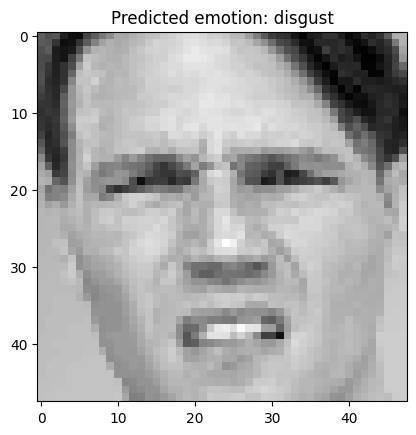

In [38]:
image = 'data/artem/1.png'
predict_emotion(image, model, label)